### Importing necessary libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


### Preprocessing

In [3]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


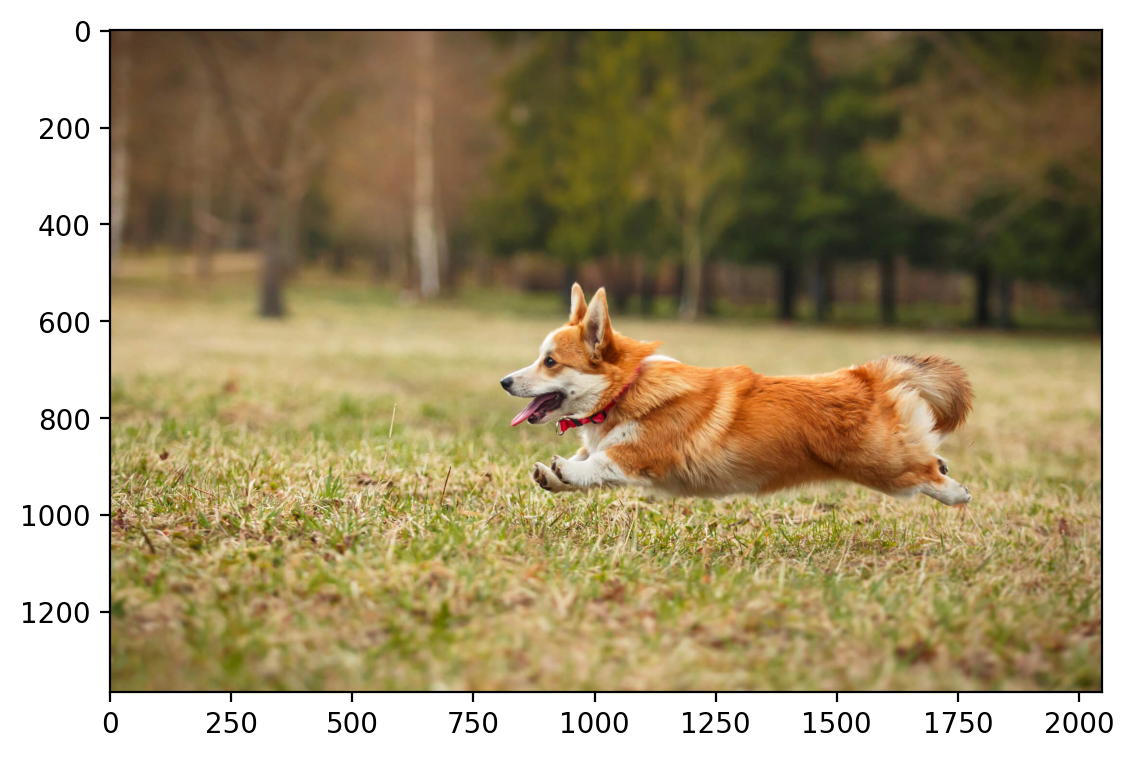

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 670, 830, 100, 100)
crop.shape

torch.Size([3, 100, 100])

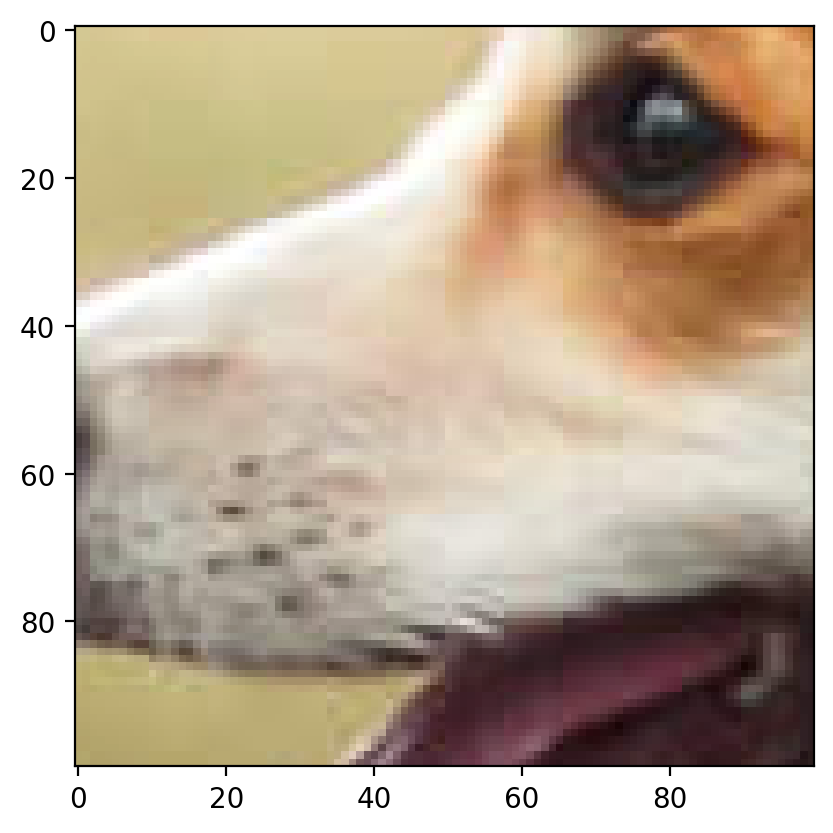

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [10]:
crop = crop.to(device)
crop.shape

torch.Size([3, 100, 100])

In [11]:
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 100 100


### Linear Model

In [12]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x):
        return self.linear(x)

In [13]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

### Creating coordinate map

In [14]:
num_channels, height, width = 2, 3, 4
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)
X = torch.stack([h_coords, w_coords], dim=1).float()

def create_coordinate_map(img, sampling_percentage):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    sampling_percentage: Percentage of coordinates to randomly sample

    return: tuple of torch.Tensor of shape (sampled_points, 2) and torch.Tensor of shape (sampled_points, num_channels)
    """
    num_channels, height, width = img.shape
    total_points = height * width
    num_sampled_points = int(total_points * sampling_percentage)
    sampled_indices = torch.randperm(total_points)[:num_sampled_points]

    w_coords = sampled_indices % width
    h_coords = sampled_indices // width
    X = torch.stack([h_coords, w_coords], dim=1).float()
    X = X.to(img.device)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    Y_sampled = Y[sampled_indices, :]

    return X, Y_sampled, h_coords, w_coords

In [15]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

### RFF Feature selection

In [16]:
f_no = 20000
sigma = 0.07

In [17]:
def create_rff_features(X, num_features, sigma, random_seed=190):
    from sklearn.kernel_approximation import RBFSampler
    import numpy as np
    np.random.seed(random_seed)
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=random_seed)
    X = X.cpu().numpy()
    X_rff = rff.fit_transform(X)
    return torch.tensor(X_rff, dtype=torch.float32).to(device)

### Prediction function

This function takes as input the samp_ratio that is the percentage of the original image pixels to be used for model training and outputs the predicted image.

In [18]:
def TrainPredPlot(coor_scale, orig_img, samp_ratio):
    dog_X, dog_Y, h_coords, w_coords = create_coordinate_map(crop,samp_ratio)

    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
    dog_X_scaled = scaler_X.transform(dog_X.cpu())
    dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
    dog_X_scaled = dog_X_scaled.float()
    X_rff = create_rff_features(dog_X_scaled, f_no, sigma)
    net = LinearModel(X_rff.shape[1], 3)
    net.to(device)
    train(net, 0.005, X_rff, dog_Y, 200)
    chann,height,width = orig_img.shape
    coords = np.array([[i/coor_scale, j/coor_scale] for i in range(width*coor_scale) for j in range(width*coor_scale)])
    Xten = torch.tensor(coords)
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Xten.cpu())
    Xten_scaled = scaler_X.transform(Xten.cpu())
    Xten_scaled = torch.tensor(Xten_scaled).to(device)
    Xten_scaled = Xten_scaled.float()
    X = create_rff_features(Xten_scaled, f_no, sigma)
    num_channels, height, width = orig_img.shape
    height*=coor_scale; width*=coor_scale
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    img_erased = torch.zeros_like(crop)
    img_erased[:, h_coords, w_coords] = crop[:, h_coords, w_coords]


    final_image = outputs.float()
    ground_truth = crop.permute(1,2,0)
    ground_truth = ground_truth.float()
    rmse = torch.sqrt(F.mse_loss(final_image, ground_truth))
    max_pixel_value = 1.0
    mse = F.mse_loss(final_image, ground_truth)
    psnr = 10 * torch.log10((max_pixel_value**2) / mse)

    print("RMSE:", rmse.item())
    print("PSNR:", psnr.item())

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(rearrange(img_erased, 'c h w -> h w c').cpu().numpy(), cmap='gray')
    axs[0].set_title('Erased Image with Sampled Coordinates')
    axs[1].imshow(outputs.cpu())
    axs[1].set_title(f"Reconstructed Image {outputs.shape}")
    axs[2].imshow(orig_img.cpu().permute(1, 2, 0))
    axs[2].set_title(f"Original Image {crop.shape}")
    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    return outputs.cpu()

Epoch 0 loss: 0.446923
Epoch 100 loss: 0.001828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.152532160282135
PSNR: 16.33277130126953


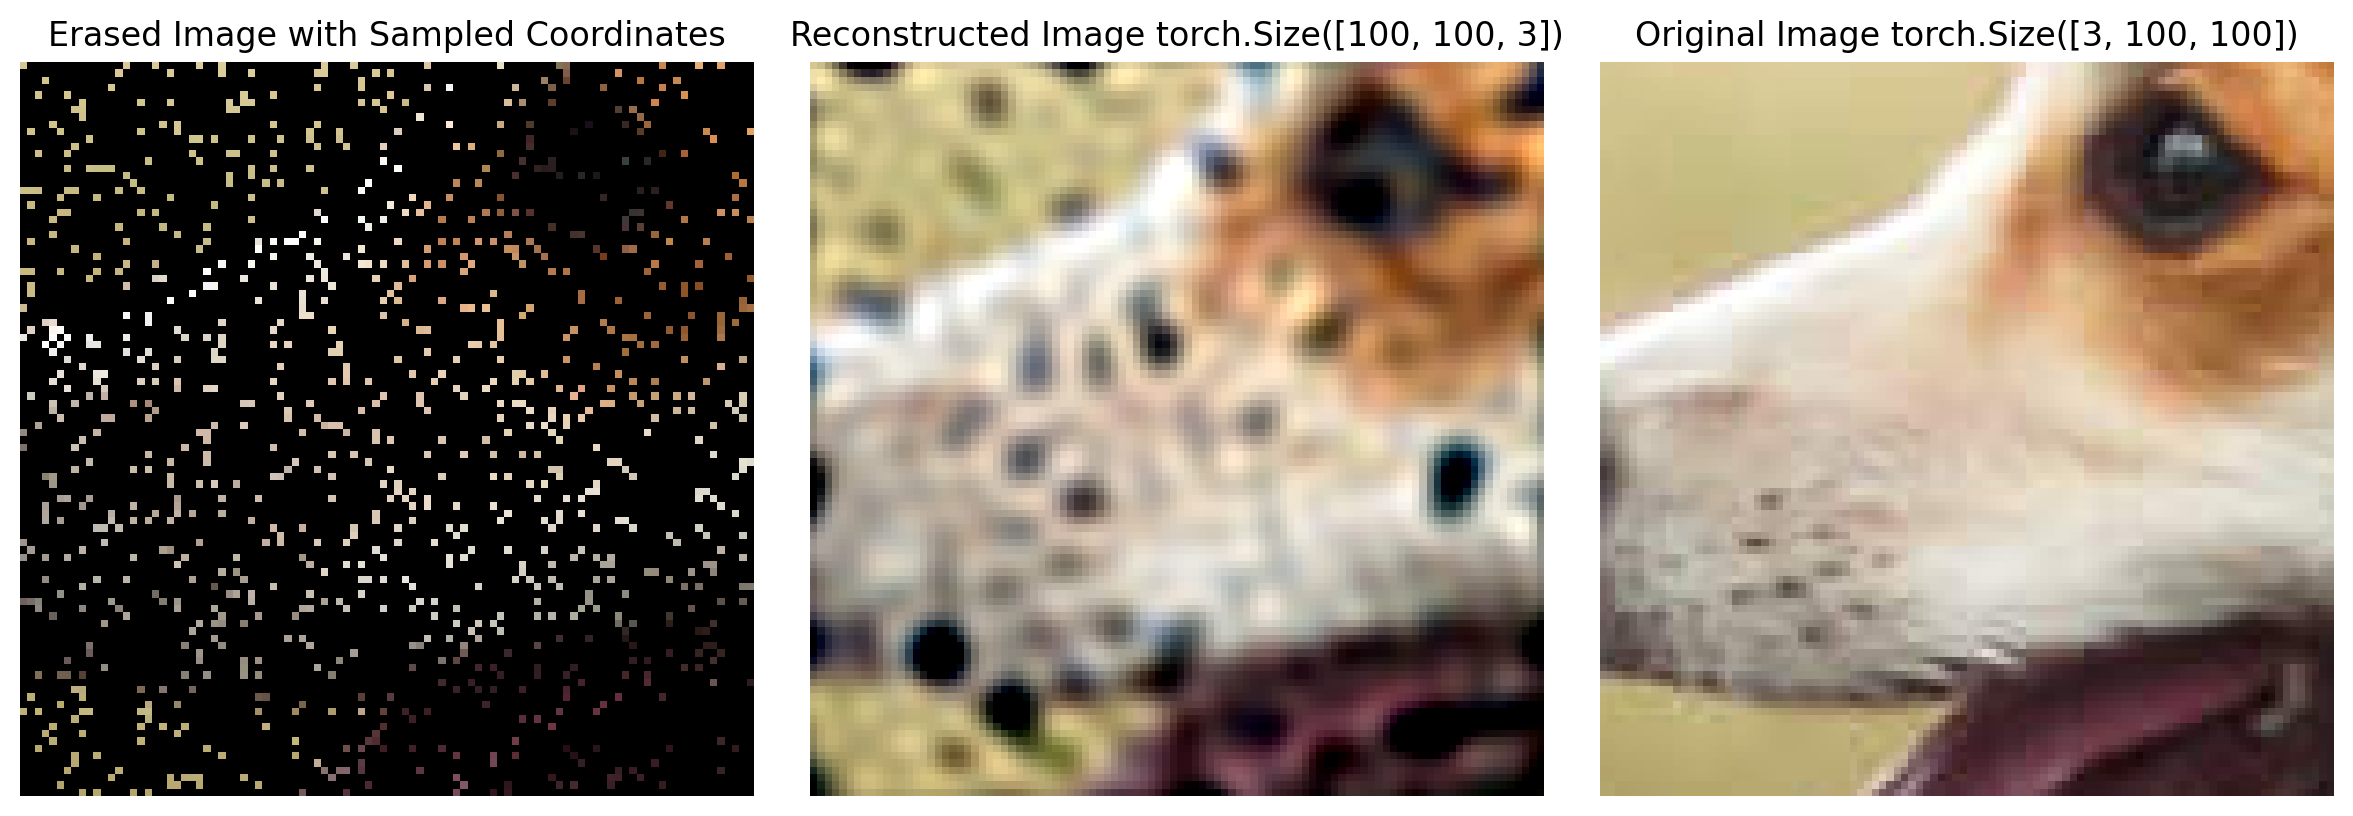

In [19]:
fimg1  = TrainPredPlot(1,crop,0.1)

Epoch 0 loss: 0.444345
Epoch 100 loss: 0.001657


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.05957811325788498
PSNR: 24.49826431274414


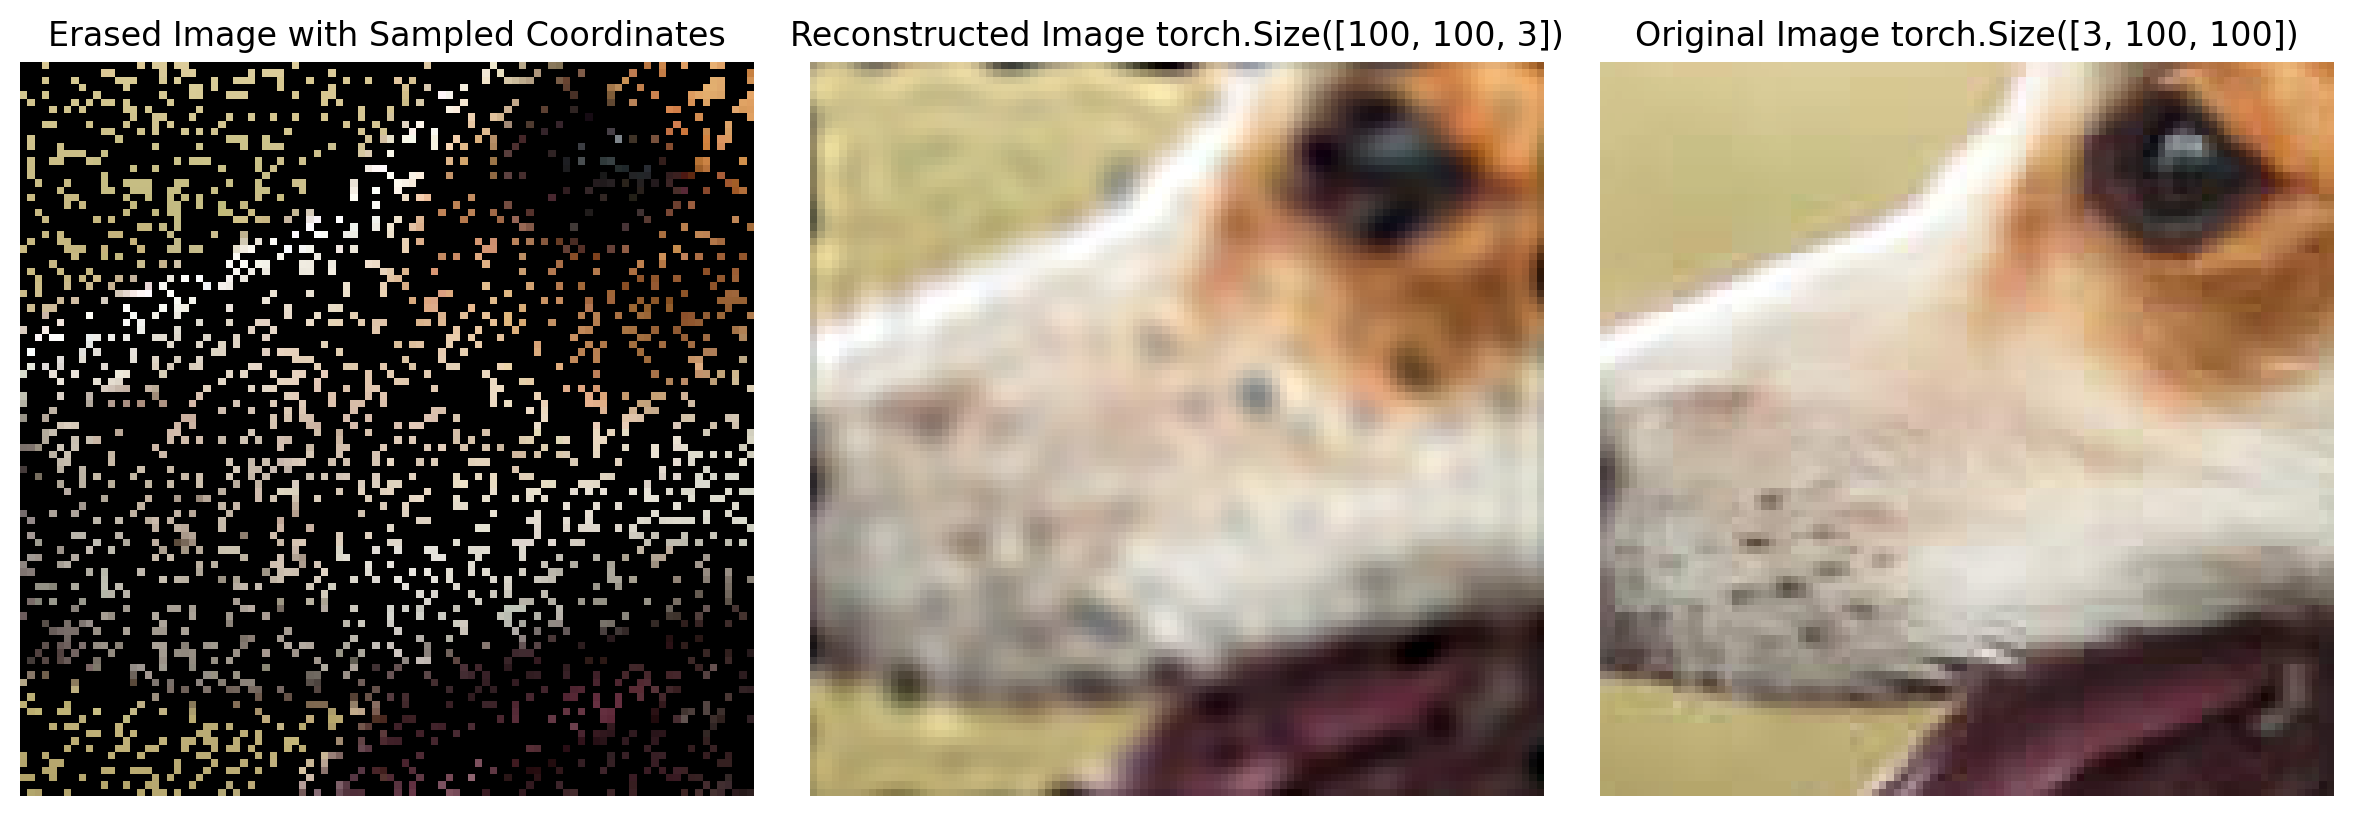

In [20]:
fimg2  = TrainPredPlot(1,crop,0.2)

Epoch 0 loss: 0.433079
Epoch 100 loss: 0.001426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.044410187751054764
PSNR: 27.05034637451172


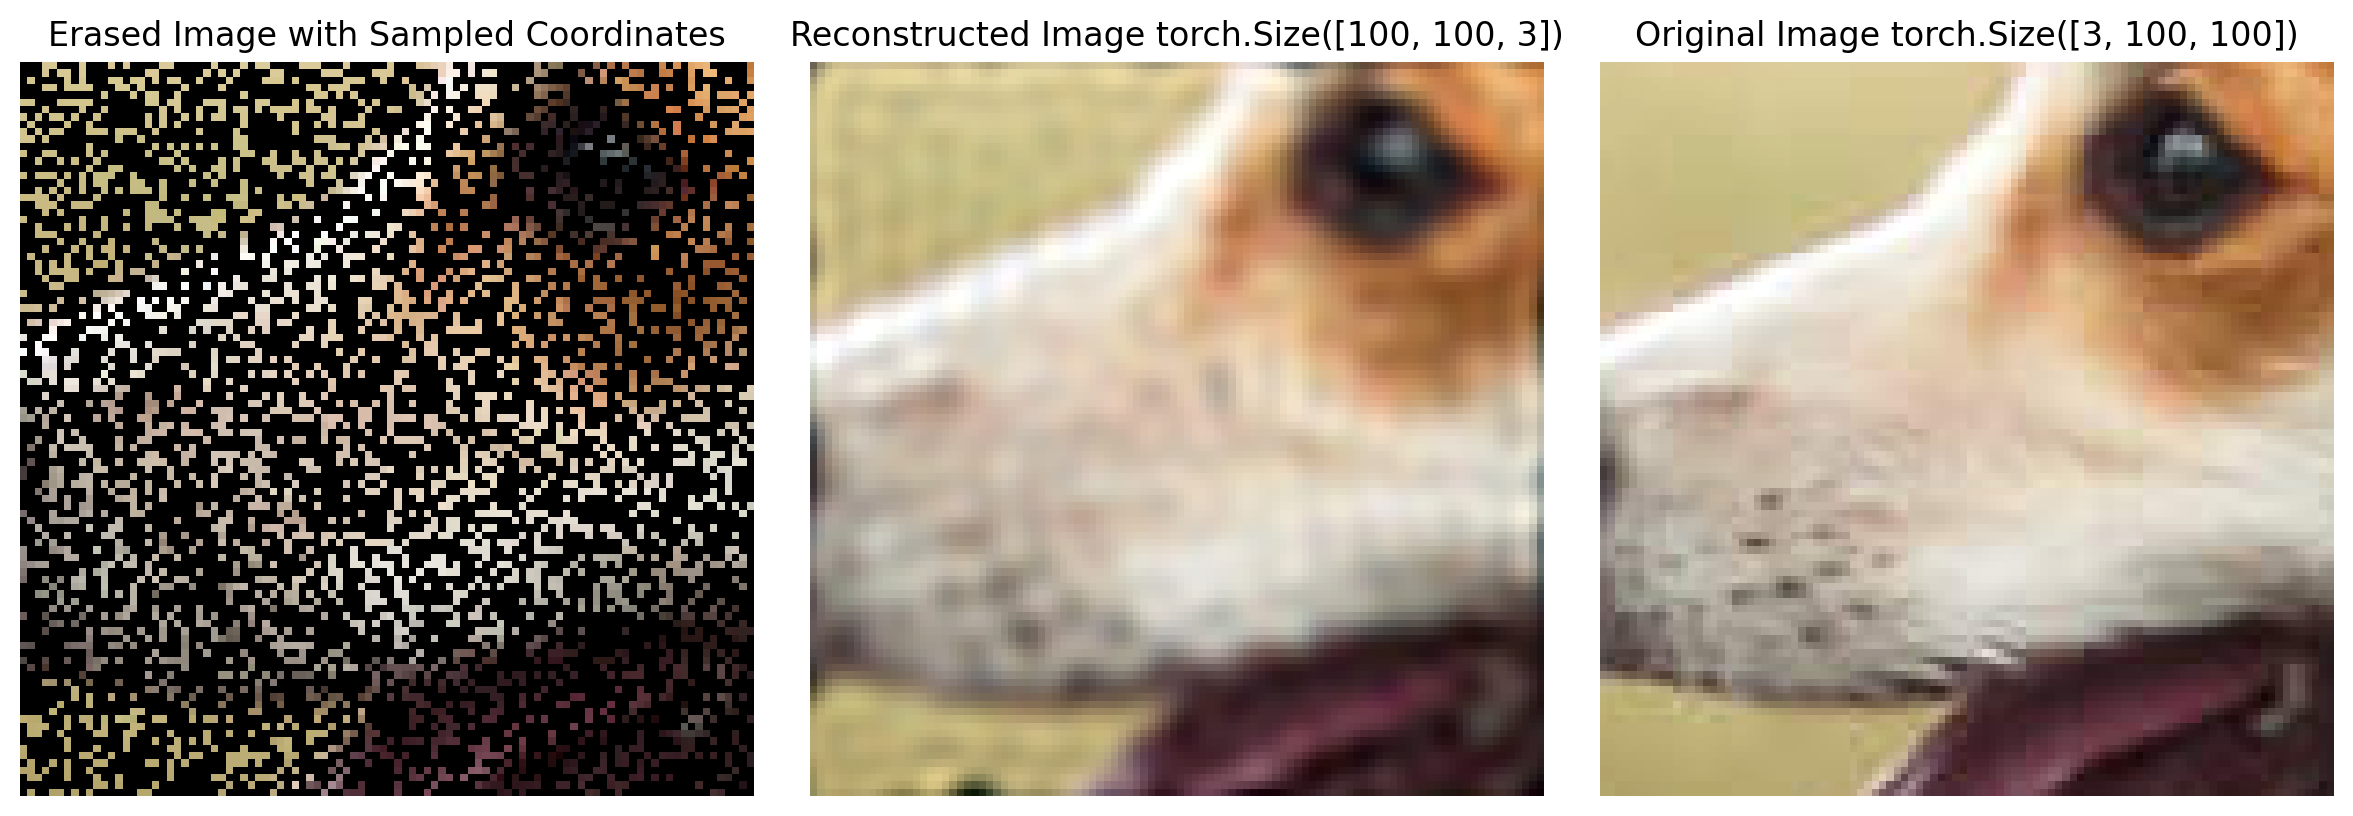

In [21]:
fimg3  = TrainPredPlot(1,crop,0.3)

Epoch 0 loss: 0.430491
Epoch 100 loss: 0.001435


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.038018014281988144
PSNR: 28.400211334228516


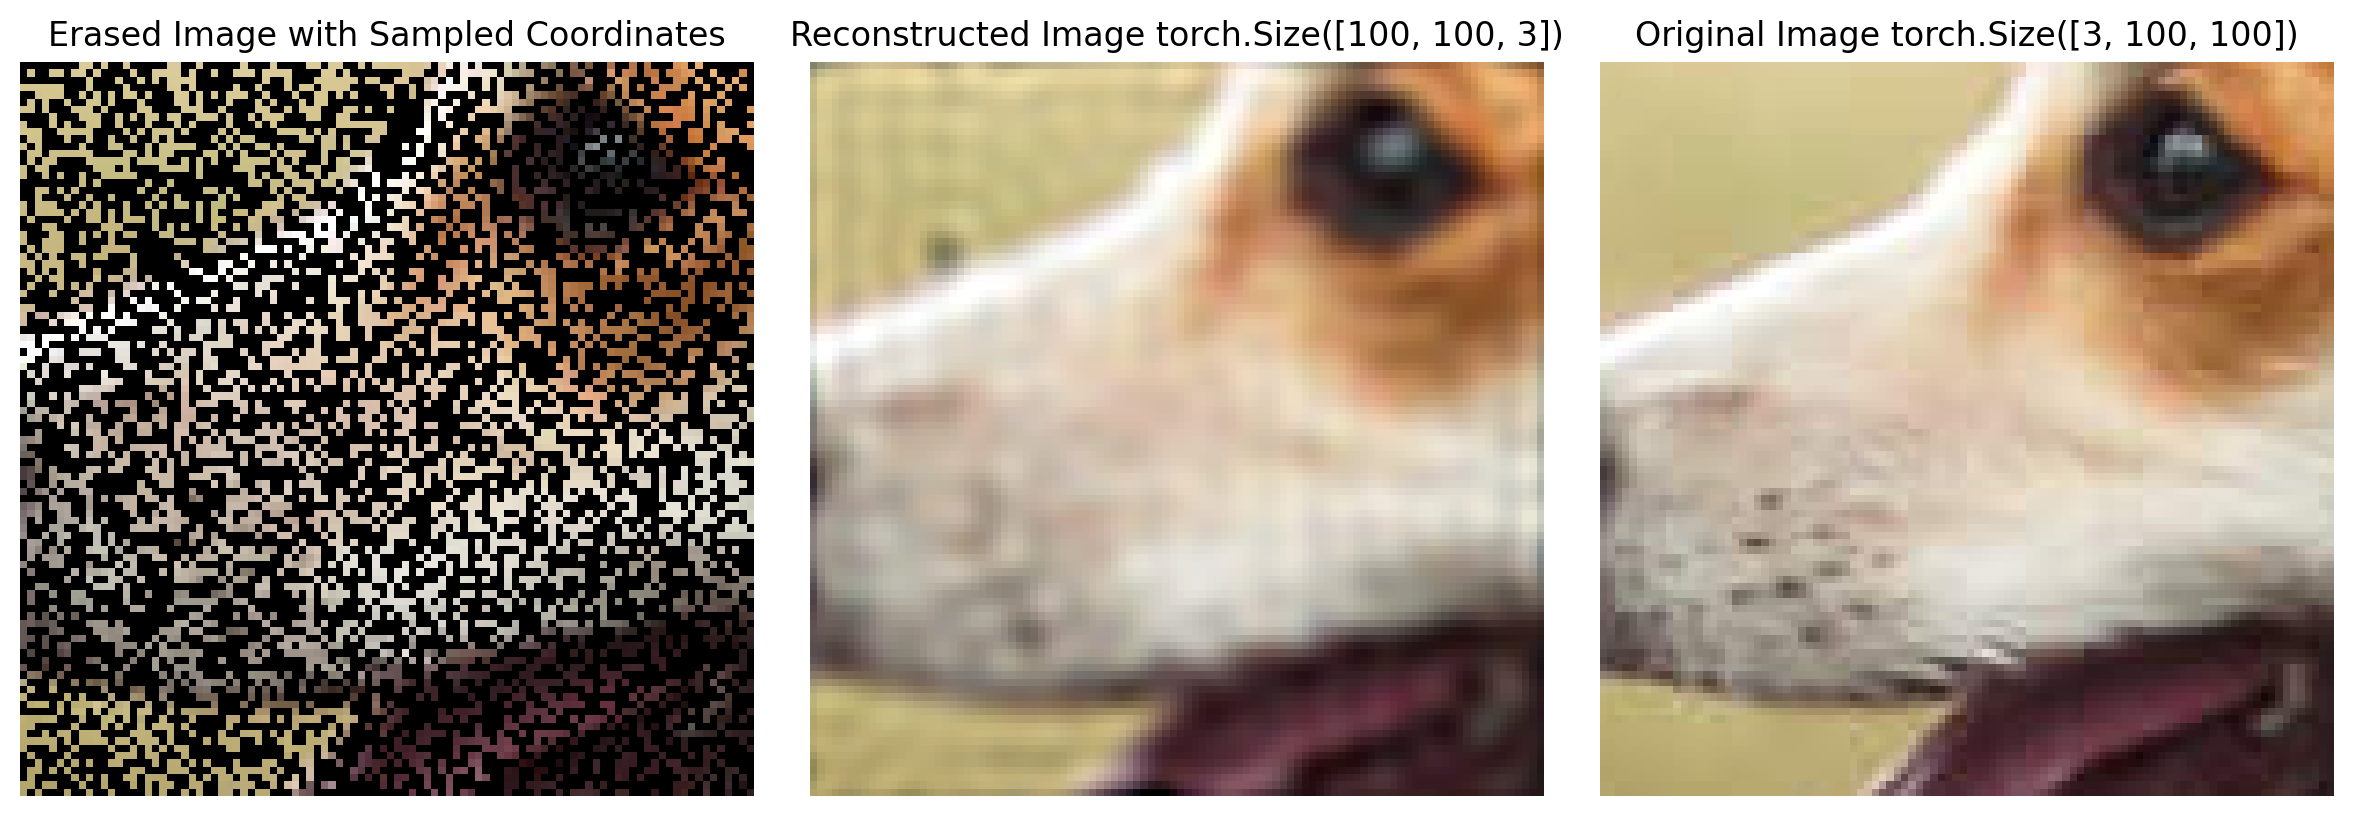

In [22]:
fimg4  = TrainPredPlot(1,crop,0.4)

Epoch 0 loss: 0.442561
Epoch 100 loss: 0.001406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.035136960446834564
PSNR: 29.084716796875


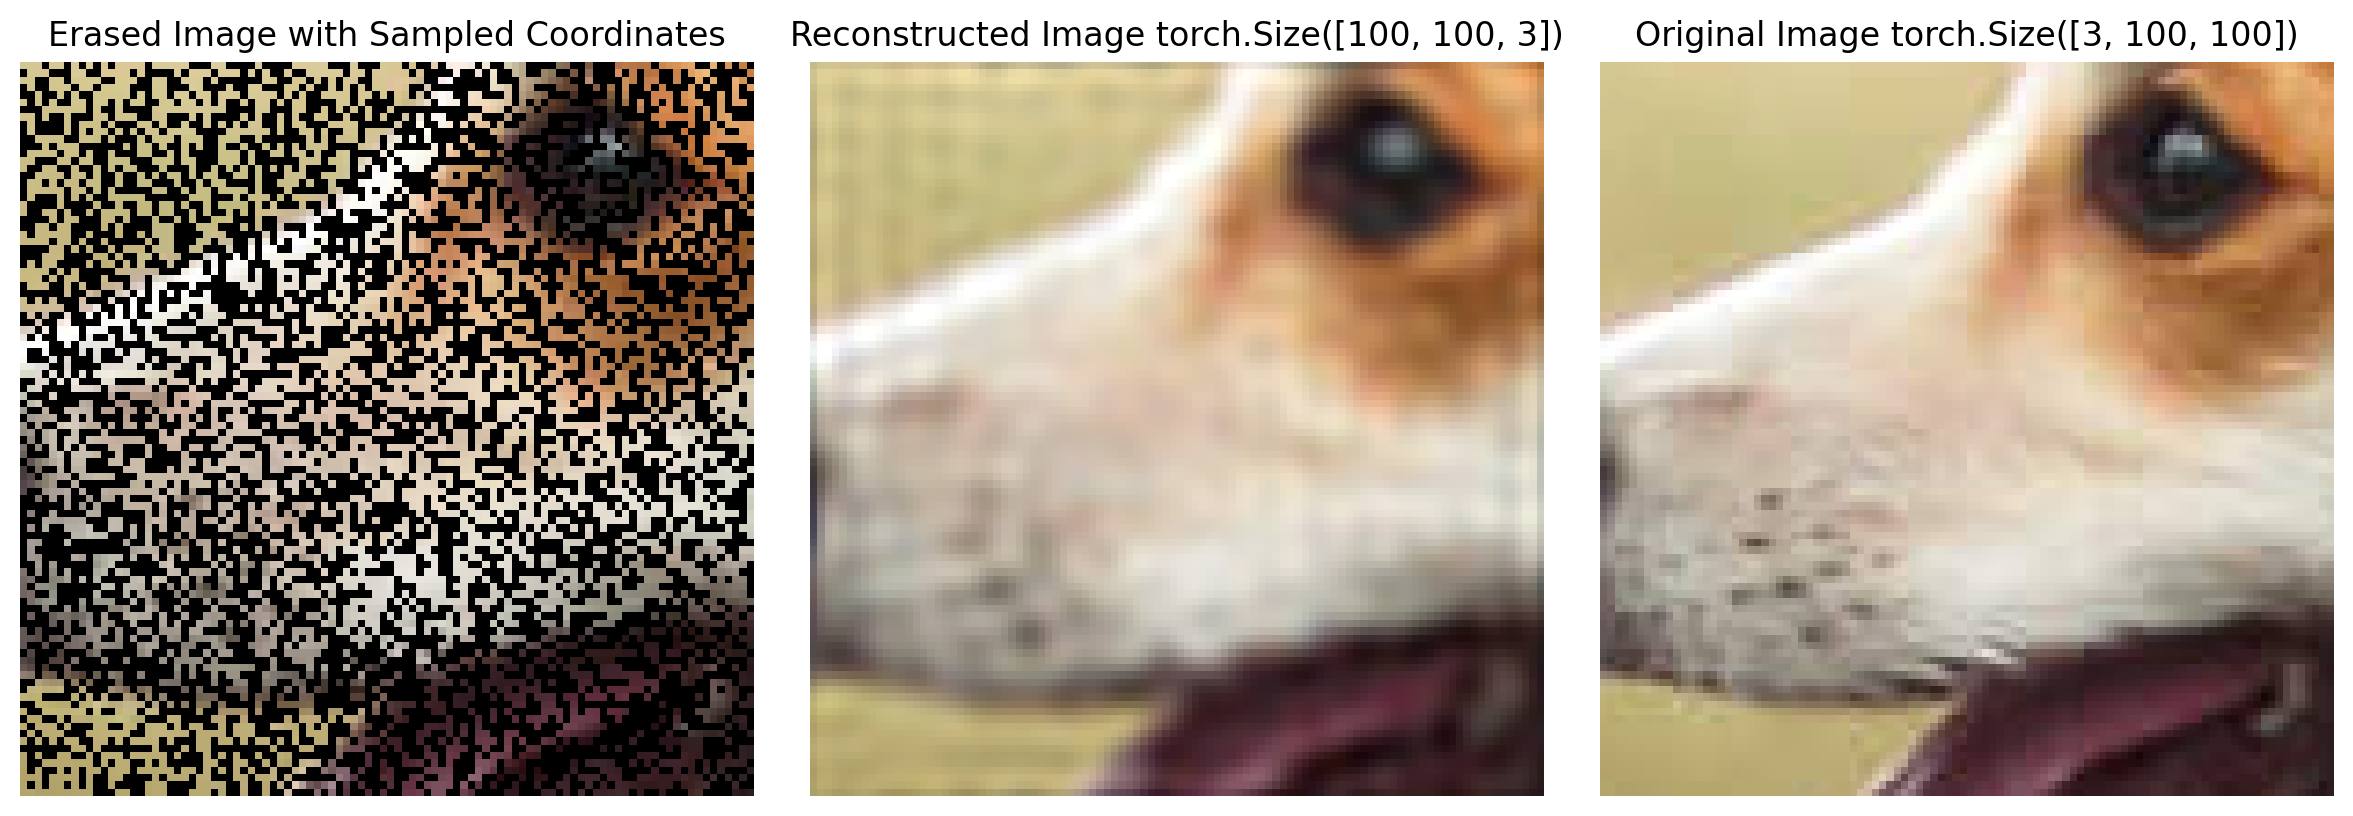

In [23]:
fimg5  = TrainPredPlot(1,crop,0.5)

Epoch 0 loss: 0.437697
Epoch 100 loss: 0.001408


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.03432563319802284
PSNR: 29.287628173828125


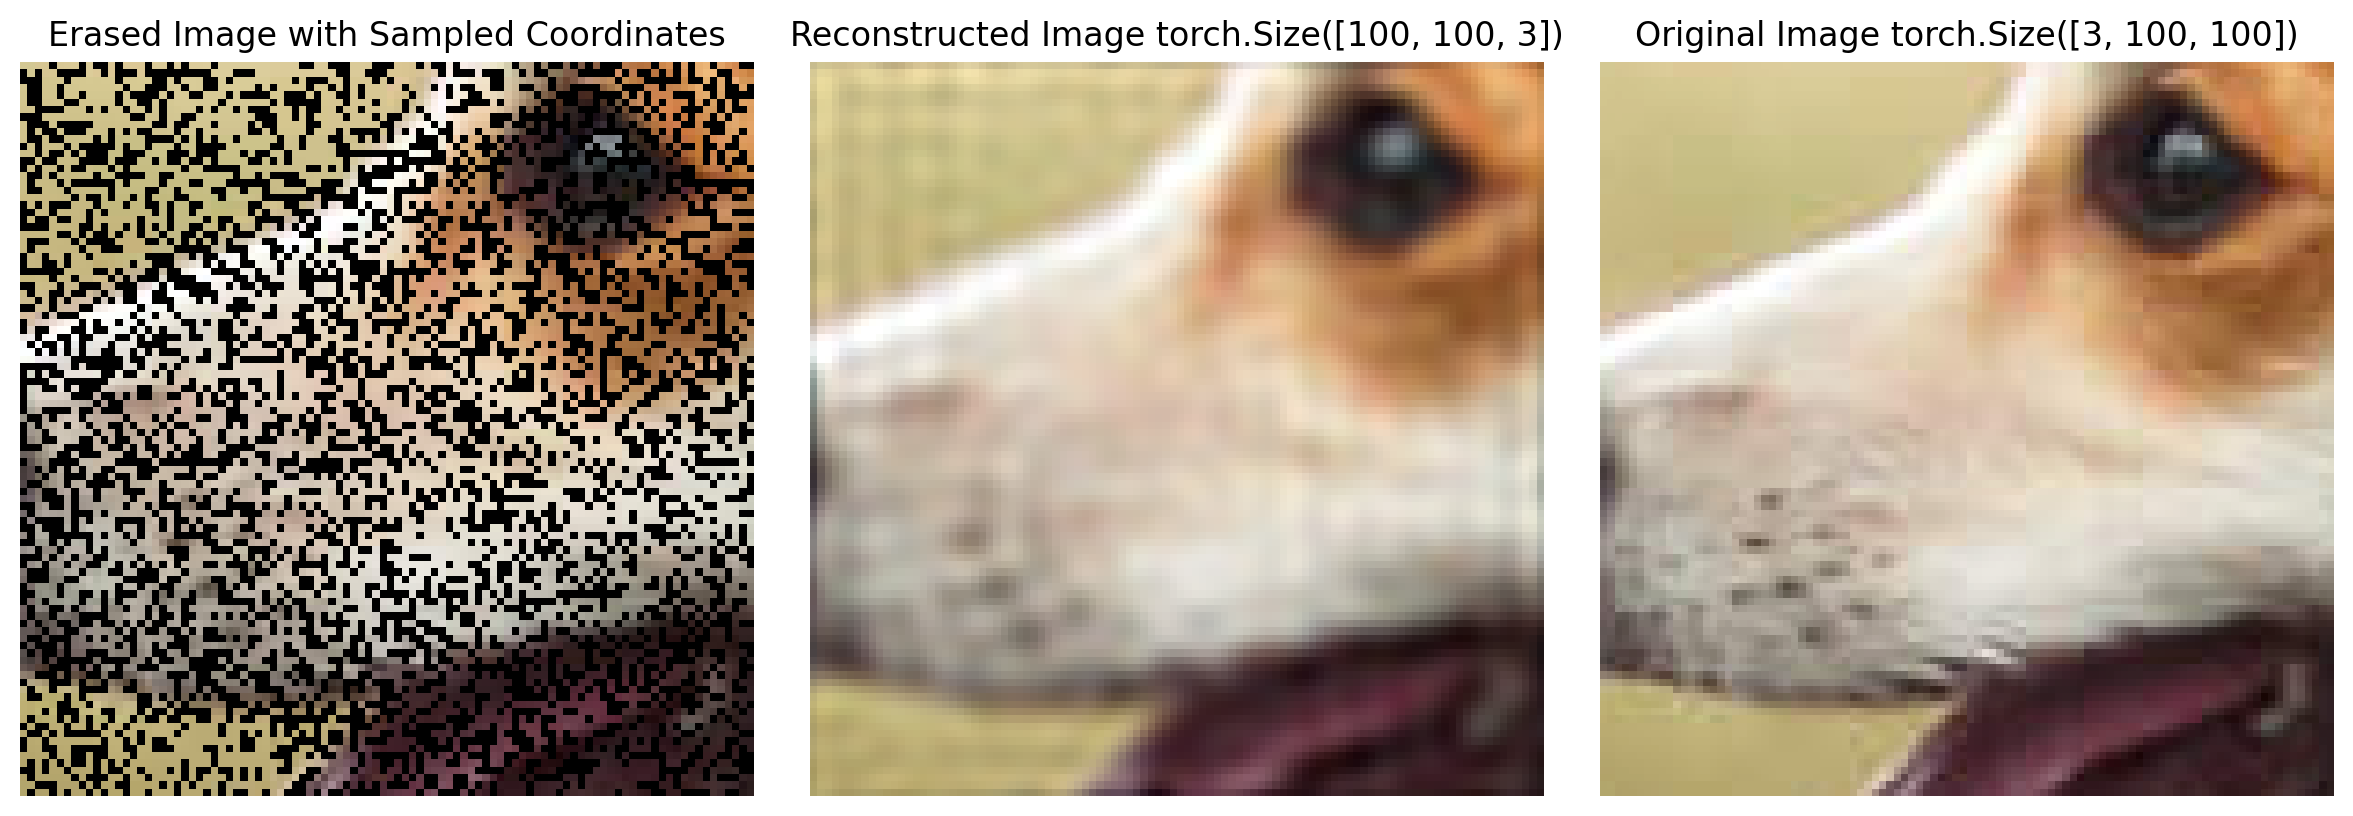

In [24]:
fimg6  = TrainPredPlot(1,crop,0.6)

Epoch 0 loss: 0.435175
Epoch 100 loss: 0.001365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.03346899524331093
PSNR: 29.507144927978516


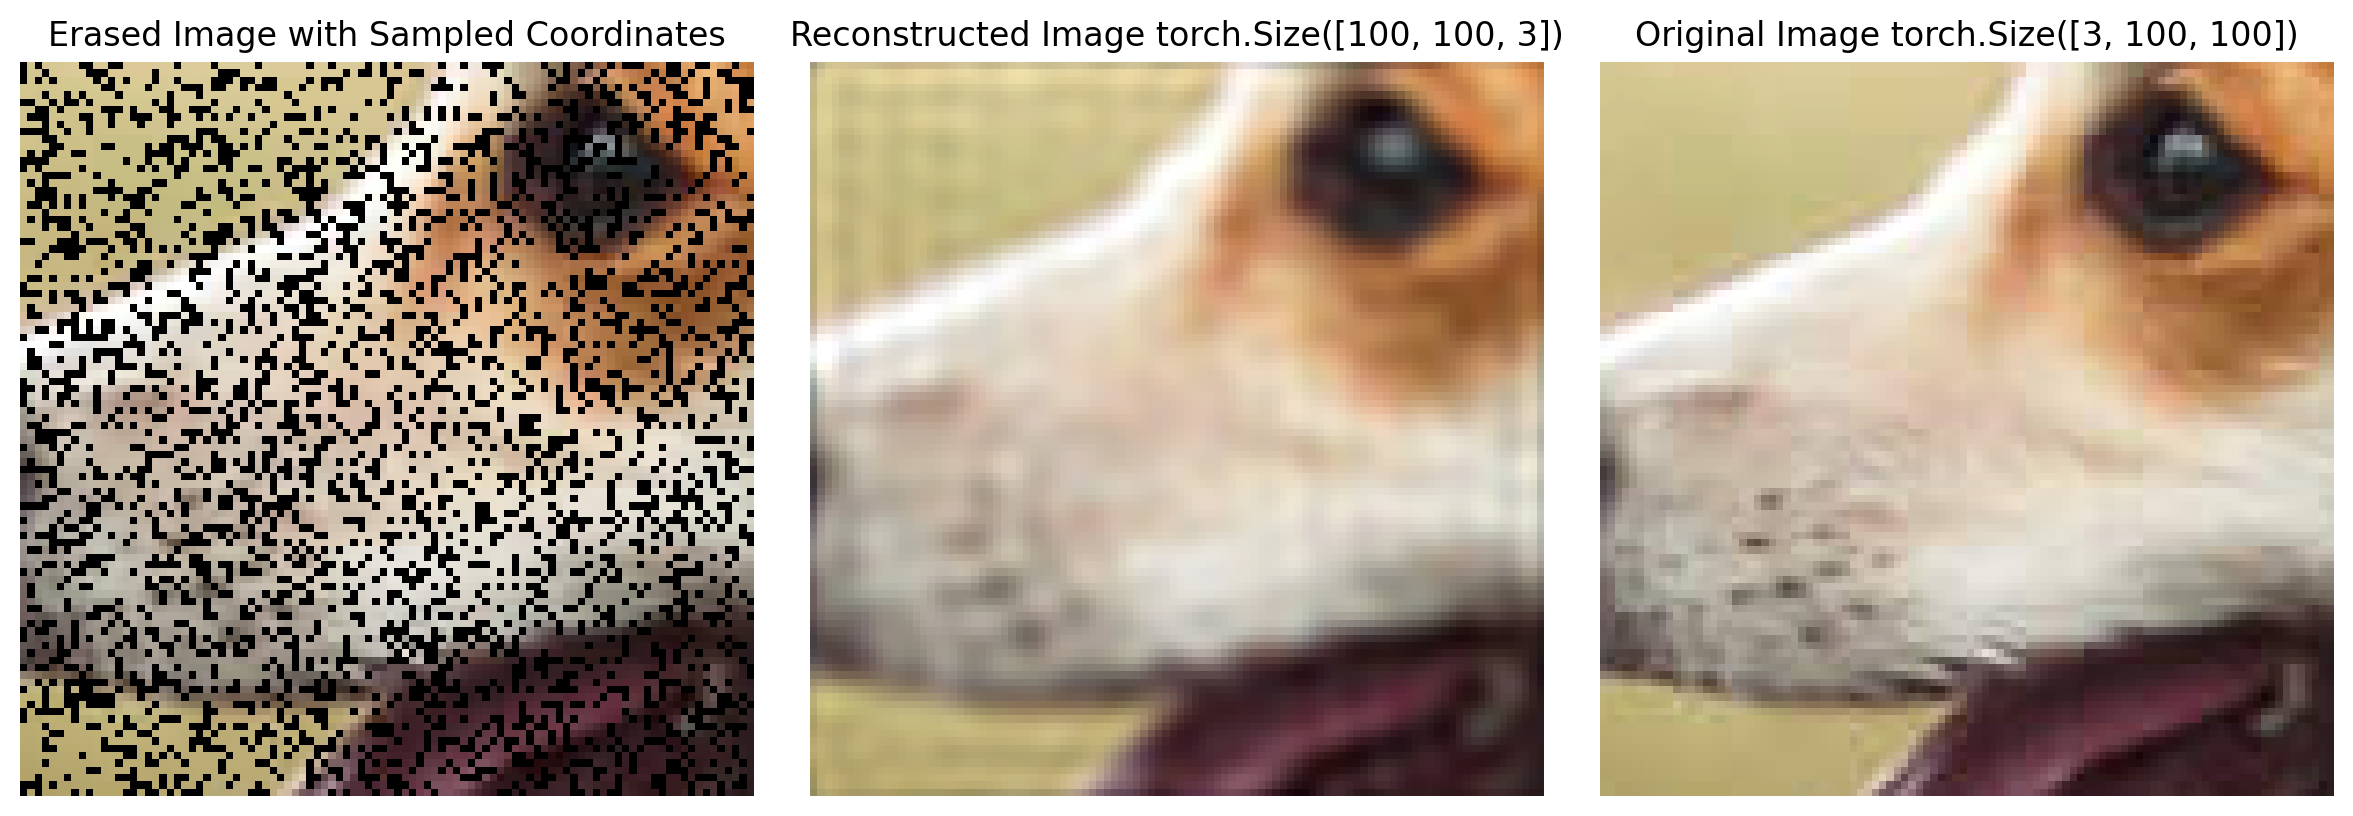

In [25]:
fimg7  = TrainPredPlot(1,crop,0.7)

Epoch 0 loss: 0.431419
Epoch 100 loss: 0.001375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.032899901270866394
PSNR: 29.65610694885254


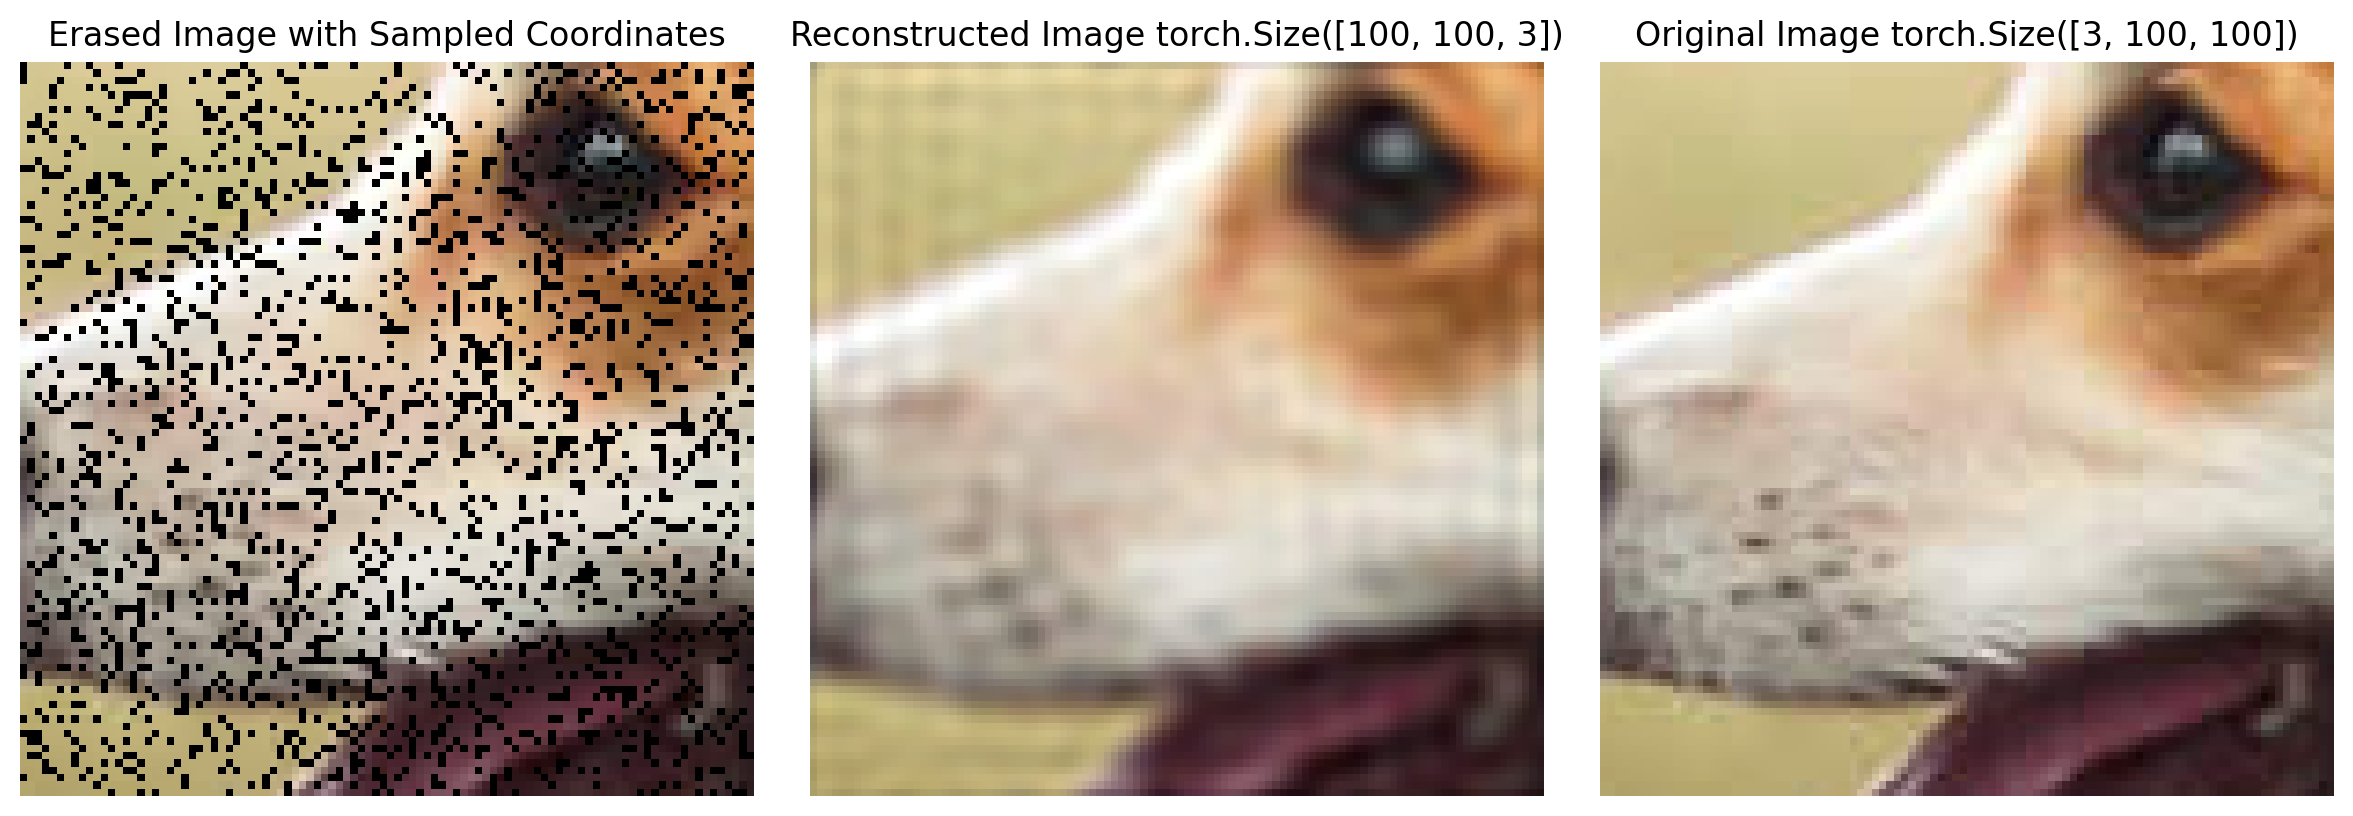

In [26]:
fimg8  = TrainPredPlot(1,crop,0.8)

Epoch 0 loss: 0.434973
Epoch 100 loss: 0.001369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.032262977212667465
PSNR: 29.825912475585938


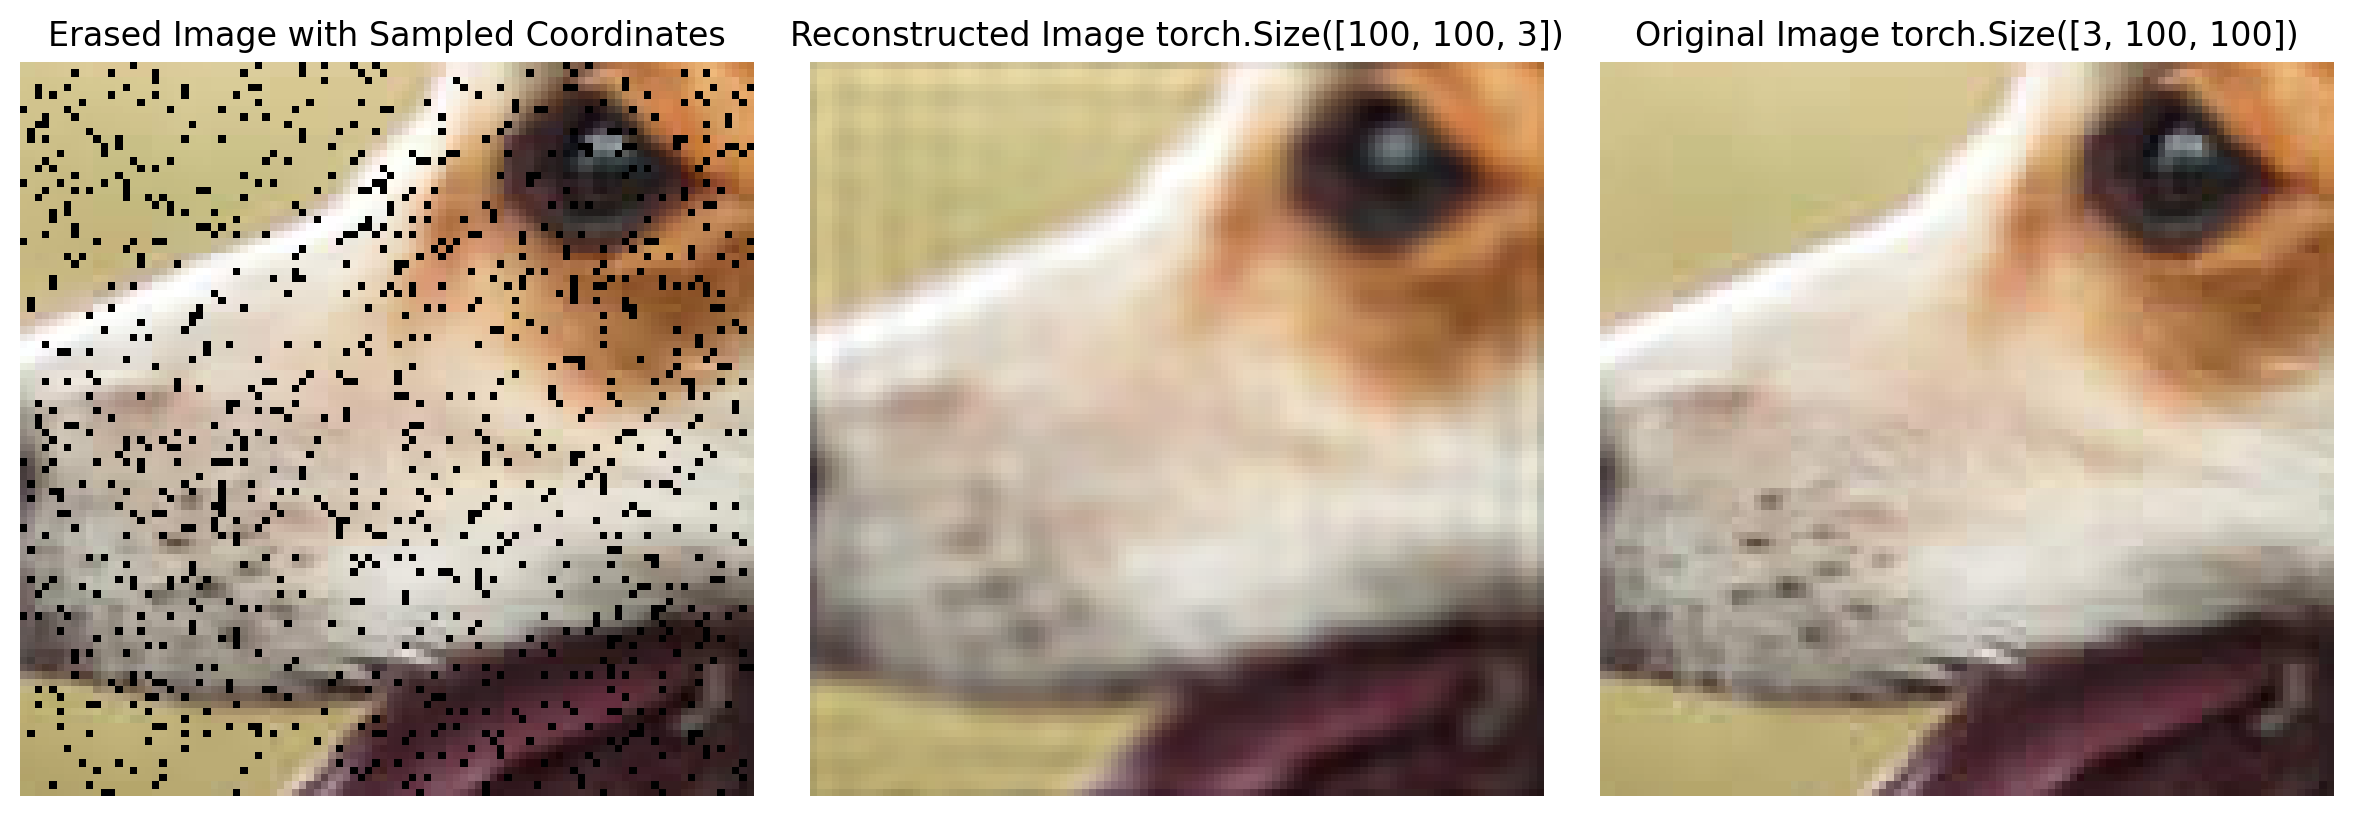

In [27]:
fimg9  = TrainPredPlot(1,crop,0.9)

Epoch 0 loss: 0.431884
Epoch 100 loss: 0.001350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.03198772668838501
PSNR: 29.900331497192383


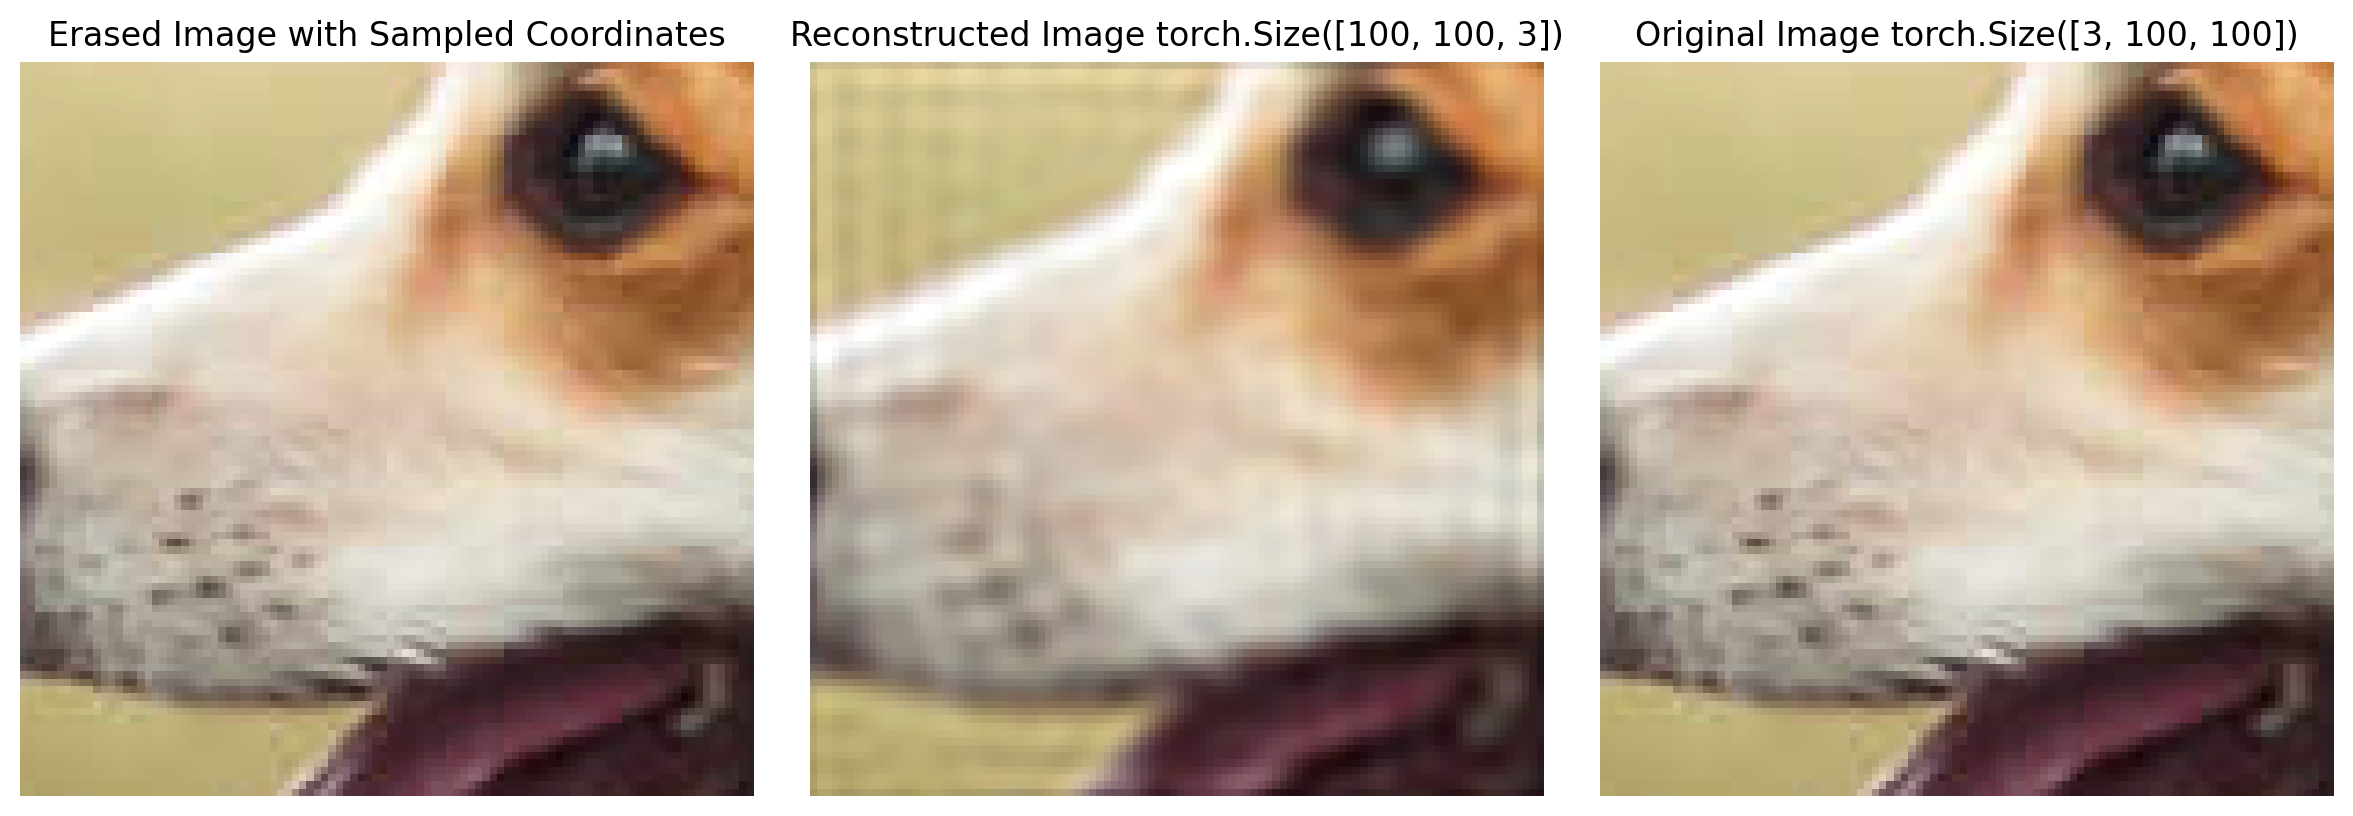

In [28]:
fimg10  = TrainPredPlot(1,crop,1)